Sources:

* [https://habrahabr.ru/post/274171/](https://habrahabr.ru/post/274171/)
* [https://habrahabr.ru/company/mlclass/blog/270973/](https://habrahabr.ru/company/mlclass/blog/270973/)

In [73]:
# coding=utf8

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

pd.set_option('display.width', 256)

In [74]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


Combine `test_data` and `train_data` to have full information.

In [75]:
all_data = pd.concat([train_data, test_data])

In [76]:
print("======== survived by class and sex")
print(train_data.groupby(["Pclass", "Sex"])["Survived"].value_counts(normalize=True))

======== survived by class and sex
Pclass  Sex     Survived
1       female  1           0.968085
                0           0.031915
        male    0           0.631148
                1           0.368852
2       female  1           0.921053
                0           0.078947
        male    0           0.842593
                1           0.157407
3       female  0           0.500000
                1           0.500000
        male    0           0.864553
                1           0.135447
dtype: float64


In [77]:
describe_fields = ["Age", "Fare", "Pclass", "SibSp", "Parch"]
# print("======== train : males")
# print(train_data[train_data["Sex"] == "male"][describe_fields].describe())
# print("======== test : males")
# print(test_data[test_data["Sex"] == "male"][describe_fields].describe())
# print("======== train : females")
# print(train_data[train_data["Sex"] == "female"][describe_fields].describe())
# print("======== test : females")
# print(test_data[test_data["Sex"] == "female"][describe_fields].describe())

Соберем небольшой дайджест по полной выборке — он будет нужен для дальшейшего преобразования выборок. В частности, нам нужны значения которые будут подставлены вместо отсутствующих, а также различные справочники для перевода текстовых значения в числовые. Дело в том, что многие классификаторы могут работать только с числами, поэтому каким-то образом мы должны перевести категориальные признаки в числовые, но независимо от способа преобразования нам будут нужны справочники этих значений. 

In [78]:
class DataDigest:

    def __init__(self):
        self.ages = None
        self.fares = None
        self.titles = None
        self.cabins = None
        self.families = None
        self.tickets = None

def get_title(name):
    if pd.isnull(name):
        return "Null"

    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1).lower()
    else:
        return "None"


def get_family(row):
    last_name = row["Name"].split(",")[0]
    if last_name:
        family_size = 1 + row["Parch"] + row["SibSp"]
        if family_size > 3:
            return "{0}_{1}".format(last_name.lower(), family_size)
        else:
            return "nofamily"
    else:
        return "unknown"


data_digest = DataDigest()
data_digest.ages = all_data.groupby("Sex")["Age"].median()
data_digest.fares = all_data.groupby("Pclass")["Fare"].median()
data_digest.titles = pd.Index(test_data["Name"].apply(get_title).unique())
data_digest.families = pd.Index(test_data.apply(get_family, axis=1).unique())
data_digest.cabins = pd.Index(test_data["Cabin"].fillna("unknown").unique())
data_digest.tickets = pd.Index(test_data["Ticket"].fillna("unknown").unique())

Теперь нам нужно выделить признаки. Как уже было сказано — многие классификаторы умеют работать только с числами, поэтому нам нужно:

* Перевести категории в числовое представление
* Выделить неявные признаки, то есть те, которые явно не заданы (титул, палуба)
* Что-то сделать с отсутствующими значениями

In [79]:
def get_index(item, index):
    if pd.isnull(item):
        return -1

    try:
        return index.get_loc(item)
    except KeyError:
        return -1


def munge_data(data, digest):
    # Age - замена пропусков на медиану в зависимости от пола
    data["AgeF"] = data.apply(lambda r: digest.ages[r["Sex"]] if pd.isnull(r["Age"]) else r["Age"], axis=1)

    # Fare - замена пропусков на медиану в зависимости от класса
    data["FareF"] = data.apply(lambda r: digest.fares[r["Pclass"]] if pd.isnull(r["Fare"]) else r["Fare"], axis=1)

    # Gender - замена
    genders = {"male": 1, "female": 0}
    data["SexF"] = data["Sex"].apply(lambda s: genders.get(s))

    # Gender - расширение
    gender_dummies = pd.get_dummies(data["Sex"], prefix="SexD", dummy_na=False)
    data = pd.concat([data, gender_dummies], axis=1)

    # Embarkment - замена
    embarkments = {"U": 0, "S": 1, "C": 2, "Q": 3}
    data["EmbarkedF"] = data["Embarked"].fillna("U").apply(lambda e: embarkments.get(e))

    # Embarkment - расширение
    embarkment_dummies = pd.get_dummies(data["Embarked"], prefix="EmbarkedD", dummy_na=False)
    data = pd.concat([data, embarkment_dummies], axis=1)

    # Количество родственников на борту
    data["RelativesF"] = data["Parch"] + data["SibSp"]

    # Человек-одиночка?
    data["SingleF"] = data["RelativesF"].apply(lambda r: 1 if r == 0 else 0)

    # Deck - замена
    decks = {"U": 0, "A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
    data["DeckF"] = data["Cabin"].fillna("U").apply(lambda c: decks.get(c[0], -1))

    # Deck - расширение
    deck_dummies = pd.get_dummies(data["Cabin"].fillna("U").apply(lambda c: c[0]), prefix="DeckD", dummy_na=False)
    data = pd.concat([data, deck_dummies], axis=1)

    # Titles - расширение
    title_dummies = pd.get_dummies(data["Name"].apply(lambda n: get_title(n)), prefix="TitleD", dummy_na=False)
    data = pd.concat([data, title_dummies], axis=1)

    # амена текстов на индекс из соответствующего справочника или -1 если значения в справочнике нет (расширять не будем)
    data["CabinF"] = data["Cabin"].fillna("unknown").apply(lambda c: get_index(c, digest.cabins))

    data["TitleF"] = data["Name"].apply(lambda n: get_index(get_title(n), digest.titles))

    data["TicketF"] = data["Ticket"].apply(lambda t: get_index(t, digest.tickets))

    data["FamilyF"] = data.apply(lambda r: get_index(get_family(r), digest.families), axis=1)

    # для статистики
    age_bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90]
    data["AgeR"] = pd.cut(data["Age"].fillna(-1), bins=age_bins).astype(object)

    return data

Преобразуем оба имеющихся набора и также опять создаем объединенный набор.

In [80]:
train_data_munged = munge_data(train_data, data_digest)
test_data_munged = munge_data(test_data, data_digest)
all_data_munged = pd.concat([train_data_munged, test_data_munged])

Хотя мы нацелились на использование Random Forest хочется попробовать и другие классификаторы. А с ними есть следующеая проблема: многие классификаторы чувствительны к масштабу признаков. Другими словами если у нас есть один признак со значениями от [-10,5] и второй признак со значениями [0,10000] то одинаковая в процентном отношении ошибка на обоих признаках будет приводить к большому отличию в абсолютном значении и классификатор будет трактовать второй признак как более важный.

Чтобы избежать этого мы приводим все числовые (а других у нас уже нет) признаки к одинаковой шкале [-1,1] и нулевому среднему значению. Сделать это в sklearn можно очень просто.

Сначала мы вычисляем коэффициенты масштабирования (снова пригодился полный набор), а затем масштабируем оба набора индивидуально.

Ну и пришел момент, когда мы можем отобрать те признаки, с которыми будем работать дальше.

In [81]:
predictors = [
              "Pclass",
              "AgeF",
              "TitleF",
              "TitleD_mr", "TitleD_mrs", "TitleD_miss", "TitleD_master", "TitleD_ms", 
              "TitleD_col", "TitleD_rev", "TitleD_dr",
              "CabinF",
              "DeckF",
              "DeckD_U", "DeckD_A", "DeckD_B", "DeckD_C", "DeckD_D", "DeckD_E", "DeckD_F", "DeckD_G",
              "FamilyF",
              "TicketF",
              "SexF",
              "SexD_male", "SexD_female",
              "EmbarkedF",
              "EmbarkedD_S", "EmbarkedD_C", "EmbarkedD_Q",
              "FareF",
              "SibSp", "Parch",
              "RelativesF",
              "SingleF"
            ]

In [82]:
scaler = StandardScaler()
scaler.fit(all_data_munged[predictors])

train_data_scaled = scaler.transform(train_data_munged[predictors])
test_data_scaled = scaler.transform(test_data_munged[predictors])

Просто ставим комментарий на ненужных и запускаем обучение. Какие именно не нужны — решать вам.


Поскольку теперь у нас появилась колонка, в которой прописан диапазон, в который попадает возраст пассажира — оценим выживаемость в зависимости от возраста (диапазона). 

In [83]:
# print("===== survived by age")
# print(train_data_munged.groupby(["AgeR"])["Survived"].value_counts(normalize=True))

# print("===== survived by gender and age")
# print(train_data_munged.groupby(["Sex", "AgeR"])["Survived"].value_counts(normalize=True))

# print("===== survived by class and age")
# print(train_data_munged.groupby(["Pclass", "AgeR"])["Survived"].value_counts(normalize=True))

Видим, что шансы на выживание велики у детей до 5 лет, а уже в пожилом возрасте шанс выжить падает с возрастом. Но это не относится к женщинам — у женщины шанс на выживаемость велик в любом возрасте. 

Попробуем визуализацию от seaborn — уж очень красивые картинки она дает, хотя я больше привык к тексту.

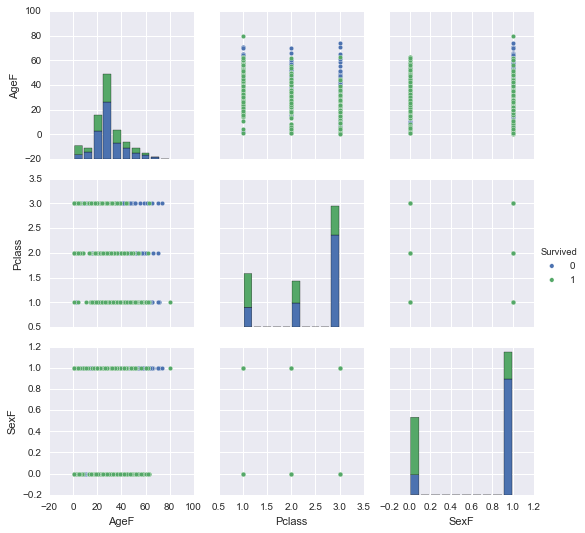

In [84]:
sns.pairplot(train_data_munged, vars=["AgeF", "Pclass", "SexF"], hue="Survived", dropna=True)
# sns.plt.show()

Оценим важность наших признаков алгоритмом SelectKBest. 

([<matplotlib.axis.XTick at 0x118a559e8>,
 <a list of 35 Text xticklabel objects>)

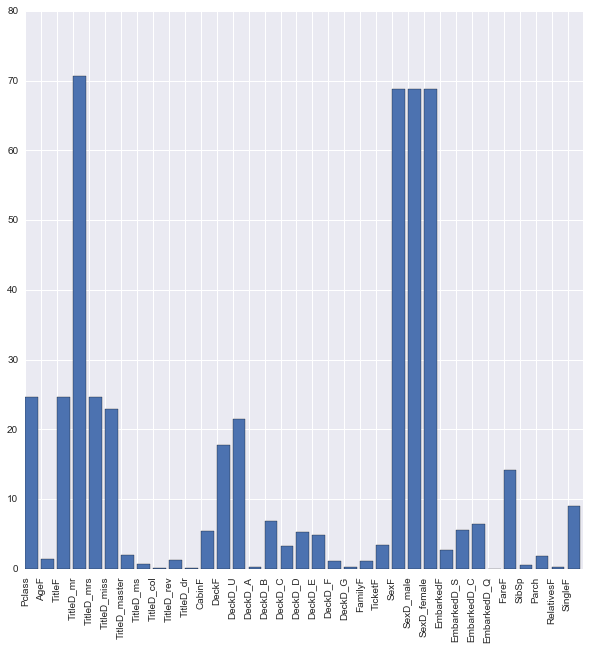

In [85]:
selector = SelectKBest(f_classif, k=5)
selector.fit(train_data_munged[predictors], train_data_munged["Survived"])

scores = -np.log10(selector.pvalues_)

plt.figure(figsize=(10,10))
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
# plt.show()

In [86]:
cv = StratifiedKFold(train_data["Survived"], n_folds=3, shuffle=True, random_state=1)

In [87]:
best_alg = None
best_score = 0

Теперь протестируем работу различных классификаторов.

#### KNeighborsClassifier:

In [88]:
alg_ngbh = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(alg_ngbh, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (k-neighbors): {}/{}".format(scores.mean(), scores.std()))

Accuracy (k-neighbors): 0.7957351290684623/0.011110544261068086


In [89]:
if scores.mean() > best_score:
    best_score = scores.mean()
    best_alg = alg_ngbh

#### SGDClassifier:

In [90]:
alg_sgd = SGDClassifier(random_state=1)
scores = cross_val_score(alg_sgd, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (sgd): {}/{}".format(scores.mean(), scores.std()))

Accuracy (sgd): 0.7239057239057239/0.015306601231185043


In [91]:
if scores.mean() > best_score:
    best_score = scores.mean()
    best_alg = alg_sgd

#### SVC:

In [92]:
alg_svm = SVC(C=1.0)
scores = cross_val_score(alg_svm, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (svm): {}/{}".format(scores.mean(), scores.std()))

Accuracy (svm): 0.8193041526374859/0.010408101566212916


In [93]:
if scores.mean() > best_score:
    best_score = scores.mean()
    best_alg = alg_svm

#### GaussianNB:

In [94]:
alg_nbs = GaussianNB()
scores = cross_val_score(alg_nbs, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (naive bayes): {}/{}".format(scores.mean(), scores.std()))

Accuracy (naive bayes): 0.6206509539842874/0.16339123708526998


In [95]:
if scores.mean() > best_score:
    best_score = scores.mean()
    best_alg = alg_nbs

#### LinearRegression:

In [96]:
def linear_scorer(estimator, x, y):
    scorer_predictions = estimator.predict(x)

    scorer_predictions[scorer_predictions > 0.5] = 1
    scorer_predictions[scorer_predictions <= 0.5] = 0

    return metrics.accuracy_score(y, scorer_predictions)

alg_lnr = LinearRegression()
scores = cross_val_score(alg_lnr, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1,
                         scoring=linear_scorer)
print("Accuracy (linear regression): {}/{}".format(scores.mean(), scores.std()))

Accuracy (linear regression): 0.8215488215488215/0.009523323652344083


/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [97]:
if scores.mean() > best_score:
    best_score = scores.mean()
    best_alg = alg_lnr

Метод `linear_scorer` нужен, поскольку `LinearRegression` — это регрессия, возвращающая любое вещественное число. Соответственно мы разделяем шкалу границей `0.5` и приводим любые числа к двум классам — `0` и `1`.

#### LogisticRegression:

In [98]:
alg_log = LogisticRegression(random_state=1)
scores = cross_val_score(alg_log, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1,
                         scoring=linear_scorer)
print("Accuracy (logistic regression): {}/{}".format(scores.mean(), scores.std()))

Accuracy (logistic regression): 0.8159371492704826/0.012396589244879071


In [99]:
if scores.mean() > best_score:
    best_score = scores.mean()
    best_alg = alg_log

#### RandomForestClassifier:

In [100]:
alg_frst = RandomForestClassifier(random_state=1, n_estimators=500, min_samples_split=8, min_samples_leaf=2)
scores = cross_val_score(alg_frst, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (random forest): {}/{}".format(scores.mean(), scores.std()))

Accuracy (random forest): 0.8294051627384961/0.004199391006480274


In [101]:
if scores.mean() > best_score:
    best_score = scores.mean()
    best_alg = alg_frst

У меня получилось примерно так

Алгоритм Random Forest победил и дисперсия у него неплохая — кажется он стабилен.


Вроде все хорошо и можно отправлять результат, но остался один мутный момент: у каждого классификатора есть свои параметры — как нам понять что мы выбрали наилучший вариант? Без сомнения можно долго сидеть и перебирать параметры вручную — но что если поручить эту работу компьютеру?

In [102]:
alg_frst_model = RandomForestClassifier(random_state=1)
alg_frst_params = [{
    "n_estimators": [350, 400, 450],
    "min_samples_split": [6, 8, 10],
    "min_samples_leaf": [1, 2, 4]
}]
alg_frst_grid = GridSearchCV(alg_frst_model, alg_frst_params, cv=cv, refit=True, verbose=1, n_jobs=-1)
alg_frst_grid.fit(train_data_scaled, train_data_munged["Survived"])
alg_frst_best = alg_frst_grid.best_estimator_
print("Accuracy (random forest auto): {} with params {}"
      .format(alg_frst_grid.best_score_, alg_frst_grid.best_params_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   29.8s finished


Accuracy (random forest auto): 0.8372615039281706 with params {'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 400}


In [103]:
if alg_frst_grid.best_score_ > best_score:
    best_score = alg_frst_grid.best_score_
    best_alg = alg_frst_best

Получается еще лучше!

Подбор можно сделать еще тоньше при наличии времени и желания — либо изменив параметры, либо используя другую стратегию подбора, например `RandomizedSearchCV`.

Все хвалят xgboost — давайте попробуем и его.

In [104]:
ald_xgb_model = xgb.XGBClassifier()
ald_xgb_params = [
    {"n_estimators": [230, 250, 270],
     "max_depth": [1, 2, 4],
     "learning_rate": [0.01, 0.02, 0.05]}
]
alg_xgb_grid = GridSearchCV(ald_xgb_model, ald_xgb_params, cv=cv, refit=True, verbose=1, n_jobs=1)
alg_xgb_grid.fit(train_data_scaled, train_data_munged["Survived"])
alg_xgb_best = alg_xgb_grid.best_estimator_
print("Accuracy (xgboost auto): {} with params {}"
      .format(alg_xgb_grid.best_score_, alg_xgb_grid.best_params_))

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   13.0s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Accuracy (xgboost auto): 0.8338945005611672 with params {'max_depth': 2, 'learning_rate': 0.02, 'n_estimators': 270}


In [105]:
if alg_xgb_grid.best_score_ > best_score:
    best_score = alg_xgb_grid.best_score_
    best_alg = alg_xgb_best

Почему-то тренировка зависала при использовании всех ядер, поэтому я ограничился одним потоком (`n_jobs=1`), но и в однопоточном режиме тренировка и классификация в xgboost работает очень быстро.

## Результат

In [113]:
alg_test = alg_frst_best
print("Best RandomForest algorithm:")
print(alg_test)
print("Accuracy (random forest auto): {}"
      .format(alg_frst_grid.best_score_))

# print("=" * 40)
# print("Best algorithm:")
# print(best_alg)
# print("best score:")
# print(best_score)
# alg_test = best_alg

alg_test.fit(train_data_scaled, train_data_munged["Survived"])

predictions = alg_test.predict(test_data_scaled)

submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": predictions
})



Best RandomForest algorithm:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=4, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
Accuracy (random forest auto): 0.8372615039281706


In [114]:
submission.to_csv("titanic-submission.csv", index=False)

In [107]:
#  0.836139169473
# sex, title: 0.793490460157 
# +age: 0.795735129068
# age, sex, title, embarked: 0.799102132435